## Import

In [1]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

N_FEATURES = 31
TIMESTEPS = 1
DATASET_LINK = "dataset/overall.csv"
TEST_DATA_LINK = "dataset/overall_test.csv"

# random seed for reproducibility
SEED = 123

### LOAD DATASET
> * Check for class imbalance

In [3]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.142176,0.156880,0.014704,0.127937,0.142299,0.014361,0.155919,...,0.128263,0.085967,-0.042296,0.120442,0.209372,0.088930,0.116911,0.165437,0.048526,0.160258
1,Andy,1,2,0.141793,0.164635,0.022842,0.121625,0.152146,0.030520,0.137039,...,0.144490,0.082397,-0.062093,0.101188,0.126066,0.024878,0.098424,0.130661,0.032238,0.173819
2,Andy,1,3,0.157152,0.147220,-0.009932,0.134796,0.145790,0.010994,0.124892,...,0.135452,0.082423,-0.053029,0.108598,0.155843,0.047244,0.118759,0.146550,0.027791,0.173512
3,Andy,1,4,0.158673,0.142487,-0.016186,0.118908,0.159179,0.040271,0.133175,...,0.114266,0.072556,-0.041711,0.101937,0.145692,0.043755,0.096300,0.122580,0.026280,0.190808
4,Andy,1,5,0.166583,0.157102,-0.009480,0.115094,0.141103,0.026009,0.135121,...,0.125474,0.089247,-0.036227,0.114211,0.149136,0.034925,0.121197,0.230113,0.108917,0.143299


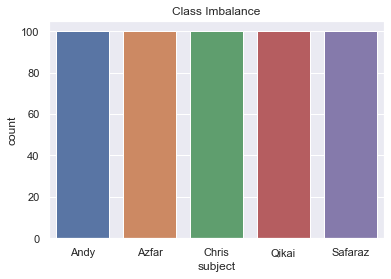

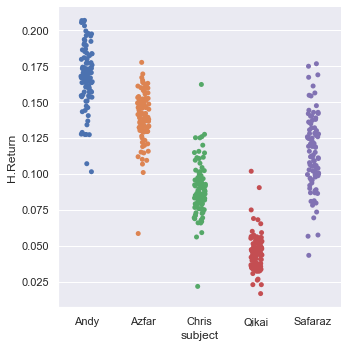

In [4]:
#################################
# # check for class imbalance # #
#################################

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

sns.catplot(x="subject", y="H.Return", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [5]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to one hot encoded Y for model
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

#################################
# # get all the encoded class # #
#################################
print("Encoder is able to decipher: ")
print(encoder.categories_[0])
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

Encoder is able to decipher: 
['Andy' 'Azfar' 'Chris' 'Qikai' 'Safaraz']


X dataset shape: (500, 31)
Y dataset shape: (500, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [6]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)


##############################################
# # normalisation and reshaping of dataset # #
##############################################
# normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
n_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (400, 1, 31)
Y train shape: (400, 5)
X test shape: (100, 1, 31)
Y test shape: (100, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [7]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=100, 
                            batch_size=10)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable folds for kfold validation

In [8]:
# from sklearn.model_selection import LeaveOneOut
def evaluate_kfold(X_train, y_train, SEED):
    
    # evaluate the model    
    folds = range(2,11)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        print(scores)
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
              (k, k_mean*100, k_min*100, k_max*100))
        
        # store mean accuracy
        means.append(k_mean)
        
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
evaluate_kfold(X_train, y_train, SEED)

KeyboardInterrupt: 

##### generate kfold validation accuracy and loss

In [ ]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    plt.show()
    
evaluate_kfold_model(X_train, y_train, SEED)

##### perform actual KFold Validation

In [9]:
# create model
model = create_model()

n_folds = 2
kfold = KFold(n_splits=n_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/100
20/20 [==============================] - 3s 3ms/step - loss: 1.6121 - accuracy: 0.3850 
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 1.1569 - accuracy: 0.5800
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.9178 - accuracy: 0.6450
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.7250
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.7600
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5847 - accuracy: 0.7750
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4822 - accuracy: 0.8100
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5206 - accuracy: 0.8150
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5403 - accuracy: 0.7950
Epoch 10/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4668 - accuracy: 0.8300
Epoch 11

20/20 [==============================] - 0s 3ms/step - loss: 0.1303 - accuracy: 0.9500
Epoch 84/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1385 - accuracy: 0.9500
Epoch 85/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0756 - accuracy: 0.9700
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1736 - accuracy: 0.9350
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9700
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1891 - accuracy: 0.9450
Epoch 89/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9600
Epoch 90/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1145 - accuracy: 0.9750
Epoch 91/100
20/20 [==============================] - 0s 3ms/step - loss: 0.2343 - accuracy: 0.9300
Epoch 92/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1128 - accuracy: 0.9600
Epoch 93/100


20/20 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9250
Epoch 65/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1317 - accuracy: 0.9600
Epoch 66/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1162 - accuracy: 0.9700
Epoch 67/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1354 - accuracy: 0.9450
Epoch 68/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1455 - accuracy: 0.9550
Epoch 69/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1496 - accuracy: 0.9500
Epoch 70/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1607 - accuracy: 0.9350
Epoch 71/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3493 - accuracy: 0.8650
Epoch 72/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1180 - accuracy: 0.9600
Epoch 73/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1810 - accuracy: 0.9350
Epoch 74/100


##### get validation accuracy

In [10]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

Validation Accuracy of 94.50% (with standard deviation of 0.00%)


### FIT MODEL FOR TESTING 
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [11]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=1)
history = model.fit(X_train, y_train, callbacks=es, verbose=1)

Epoch 1/100
40/40 [==============================] - 3s 3ms/step - loss: 1.3367 - accuracy: 0.4875
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.8441 - accuracy: 0.6850
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.7700
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5802 - accuracy: 0.8075
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4686 - accuracy: 0.8250
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4445 - accuracy: 0.8525
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4559 - accuracy: 0.8300
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3913 - accuracy: 0.8825
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3869 - accuracy: 0.8475
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3912 - accuracy: 0.8700
Epoch 11/

40/40 [==============================] - 0s 4ms/step - loss: 0.1264 - accuracy: 0.9625
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1247 - accuracy: 0.9450
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.9700
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0950 - accuracy: 0.9650
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1078 - accuracy: 0.9650
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.9600
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0951 - accuracy: 0.9725
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0943 - accuracy: 0.9650
Epoch 91/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0712 - accuracy: 0.9775
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9625
Epoch 93/100


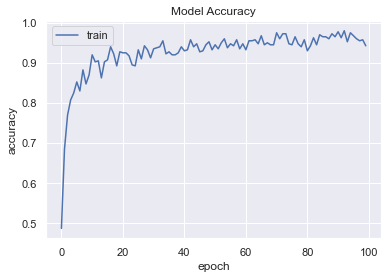

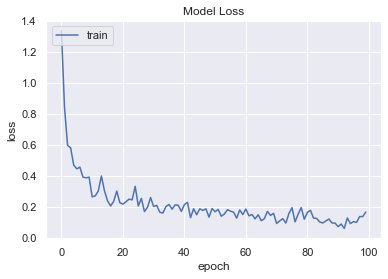

In [12]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [13]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            81920     
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 1, 128)           512       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_7 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_7 (Batc  (None, 1, 128)           512       
 hNormalization)                                      

### MODEL TESTING
> * get model accuracy on the test dataset
> * generate confusion matrix
> * generate ROC curves
> * save the model if appropriate

In [14]:
y_pred = model.predict(X_test)
y_pred = to_categorical(y_pred)

# evaluate predictions
acc = accuracy_score(y_test, y_pred)
print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 94.000%


##### Confusion Matrix

<AxesSubplot:>

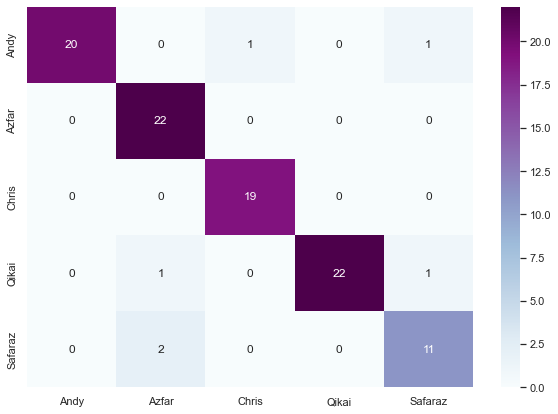

In [15]:
# confusion matrix
cm = confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred))
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(encoder.inverse_transform(y_test))],
                     columns = [i for i in np.unique(encoder.inverse_transform(y_test))])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

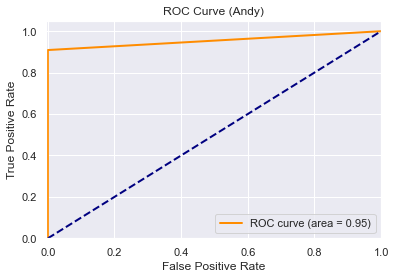

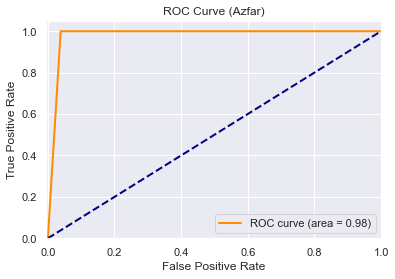

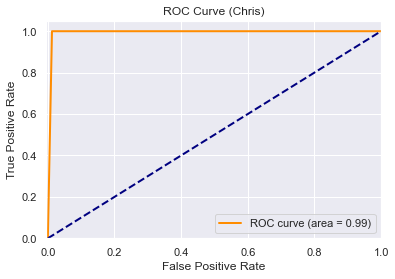

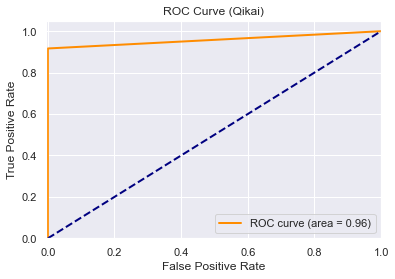

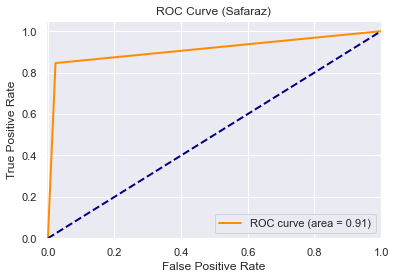

In [17]:
# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (" + str(encoder.categories_[0][i]) + ")")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Combined Plot)

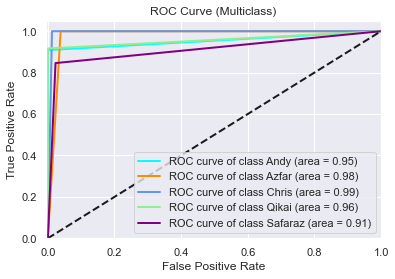

In [18]:
# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(encoder.categories_[0][i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

##### ROC Curve (Average out)

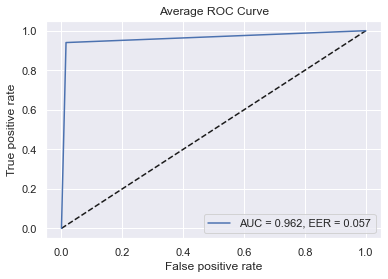

In [19]:
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate equal-error-rate
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Average ROC Curve')
plt.legend(loc='best')
plt.show()

### FIT AND SAVE MODEL
> * fitting of model
> * get accuracy and loss of model
> * saving model

In [20]:
##############################################
# # normalisation and reshaping of dataset # #
##############################################
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to one hot encoded Y for model
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

# # normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)

# reshaping the dataset to include LSTM Timesteps
X = np.asarray(X, dtype=np.float32)
X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

Epoch 1/100
50/50 [==============================] - 3s 2ms/step - loss: 1.4287 - accuracy: 0.4760
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 0.8821 - accuracy: 0.6600
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.7640
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 0.5284 - accuracy: 0.8040
Epoch 5/100
50/50 [==============================] - 0s 3ms/step - loss: 0.5379 - accuracy: 0.8140
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 0.4583 - accuracy: 0.8280
Epoch 7/100
50/50 [==============================] - 0s 3ms/step - loss: 0.4431 - accuracy: 0.8360
Epoch 8/100
50/50 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8680
Epoch 9/100
50/50 [==============================] - 0s 3ms/step - loss: 0.3860 - accuracy: 0.8820
Epoch 10/100
50/50 [==============================] - 0s 3ms/step - loss: 0.3486 - accuracy: 0.8820
Epoch 11/

50/50 [==============================] - 0s 3ms/step - loss: 0.1048 - accuracy: 0.9580
Epoch 84/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9580
Epoch 85/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1089 - accuracy: 0.9660
Epoch 86/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.9580
Epoch 87/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1206 - accuracy: 0.9500
Epoch 88/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.9840
Epoch 89/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0783 - accuracy: 0.9700
Epoch 90/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1193 - accuracy: 0.9680
Epoch 91/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1348 - accuracy: 0.9580
Epoch 92/100
50/50 [==============================] - 0s 3ms/step - loss: 0.1019 - accuracy: 0.9640
Epoch 93/100


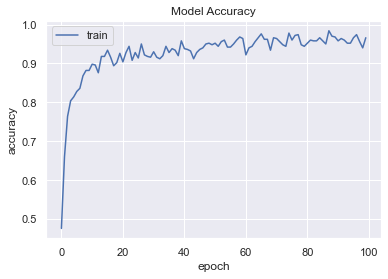

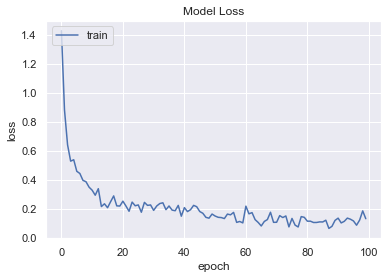

In [21]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### SAVE MODEL

In [22]:
##################
# # save model # #
##################

model.model.save("model/ohe_key_classifier.h5")

###########################
# # save model in colab # #
###########################

# model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LOAD MODEL

In [23]:
# # ##################
# # # # load model # #
# # ##################

# # model = create_model()
# model = load_model("model/key_classifier.h5")

# # ###########################
# # # # load model in colab # #
# # ###########################

# # # model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [24]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.174239,0.409866,0.235627,0.133840,0.171659,0.037820,0.156984,...,0.137544,0.091721,-0.045824,0.099726,0.099142,-0.000585,0.120912,0.135934,0.015022,0.163508
1,Andy,1,2,0.145289,0.154851,0.009562,0.131217,0.129134,-0.002083,0.130980,...,0.164865,0.111584,-0.053281,0.101935,0.023678,-0.078258,0.140863,0.192325,0.051462,0.156958
2,Andy,1,3,0.122266,0.136321,0.014055,0.114905,0.125308,0.010402,0.144332,...,0.145501,0.095982,-0.049520,0.121049,0.091486,-0.029563,0.111422,0.145751,0.034329,0.169304
3,Andy,1,4,0.121075,0.132562,0.011487,0.134813,0.132049,-0.002763,0.135681,...,0.135072,0.089715,-0.045356,0.117885,0.089209,-0.028676,0.098095,0.139069,0.040974,0.168298
4,Andy,1,5,0.141361,0.124721,-0.016640,0.098268,0.149003,0.050735,0.128713,...,0.121480,0.078897,-0.042583,0.108607,0.049435,-0.059172,0.131348,0.156398,0.025050,0.170112


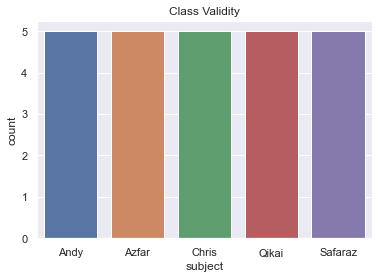

In [25]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [34]:
pred_dataset = pred_df.values

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[0:1,3:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
# pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

In [35]:
####################################
# # get prediction and its label # #
####################################
pred = model.predict(pred_arr)
pred = to_categorical(pred)
pred = encoder.inverse_transform(pred)
pred = np.ravel(pred)

pred_proba = model.predict_proba(pred_arr)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

   Prediction  Accuracy
0        Andy  0.993149
1        Andy  0.988323
2        Andy  0.975306
3        Andy  0.995133
4        Andy    0.9265
5       Azfar  0.999538
6       Azfar  0.996467
7       Azfar  0.992804
8       Azfar  0.996154
9       Azfar  0.998694
10      Chris  0.960651
11      Chris  0.984993
12      Chris  0.998281
13      Chris  0.998791
14      Chris  0.993511
15      Qikai  0.976808
16      Qikai  0.998199
17      Qikai  0.998245
18      Qikai  0.998113
19      Qikai  0.996369
20    Safaraz  0.999406
21    Safaraz  0.996344
22    Safaraz    0.9773
23    Safaraz  0.979906
24    Safaraz  0.983506
